In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import mplhep as hep 
import uproot
from scipy.stats import bootstrap
import re
import sys
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, fcluster
plt.style.use(hep.style.CMS)

In [4]:
# Open the ROOT file and extract the tree
file = uproot.open("output_0.root")
tree = file["EdepCounter"]  # Adjust if the tree name differs

# Convert to pandas DataFrame
df = tree.arrays(library="pd")

# Group by EventID and compute sum of Edep_MeV
sum_edep = df.groupby('EventID')['Edep_MeV'].sum()

# Filter events where sum > 1 MeV
filtered_events = sum_edep[sum_edep > 1].index

# Get the filtered DataFrame (all rows for those EventIDs)
filtered_df = df[df['EventID'].isin(filtered_events)]

# Save to CSV
filtered_df.to_csv('filtered_events.csv', index=False)

/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(ak.is_none(self._data))
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(ak.is_none(self._data))
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: Dep

In [ ]:
data=pd.read_csv('filtered_events.csv')
index=data.groupby('EventID')['Edep_MeV'].count()<=4
filtered_data=data[data['EventID'].isin(index[index].index)]
index=filtered_data.groupby('EventID')['Edep_MeV'].count()>=3
filtered_data=filtered_data[filtered_data['EventID'].isin(index[index].index)]

In [325]:
# Load the ROOT file (adjust path if needed)
file = uproot.open("output_0.root")
tree = file["EdepCounter"]
data = tree.arrays(library="pd")

# Group by EventID
grouped = data.groupby('EventID')

# For each event, remove detectors with Edep > 0.6 MeV and sum the remaining
remaining_sums = []
for event_id, group in grouped:
    # Filter out high-energy detectors (>0.6 MeV)
    low_edep_group = group[group['Edep_MeV'] <= 0.6]
    # Sum the remaining Edep
    sum_remaining = low_edep_group['Edep_MeV'].sum()
    remaining_sums.append((event_id, sum_remaining))

# Create DataFrame of results
results_df = pd.DataFrame(remaining_sums, columns=['EventID', 'RemainingSum_MeV'])

# Filter events where remaining sum is approximately 1 MeV (using tolerance of 0.05 MeV; adjust as needed)
filtered_events = results_df[np.isclose(results_df['RemainingSum_MeV'], 1.0, atol=0.05)]

# Get full data for these events
selected_data = data[data['EventID'].isin(filtered_events['EventID'])]

# Save to CSV (or print)
selected_data.to_csv('selected_events_remaining_sum_1MeV.csv', index=False)

/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(ak.is_none(self._data))
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(ak.is_none(self._data))
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/awkward_pandas/array.py:120: Dep

In [5]:
test=pd.read_csv('selected_events_remaining_sum_1MeV.csv')
test.groupby('EventID')['Edep_MeV'].count()
len(test['EventID'].unique())

17772

In [327]:
# Print for verification
pd.read_csv('selected_events_remaining_sum_1MeV.csv')

,EventID,DetectorName,Edep_MeV,FirstTime_ns
0,1,Hexagonal/UntitledPrism12.2mmcalor_unit_169,1.274551,0.0
1,1,Hexagonal/UntitledPrism12.2mmcalor_unit_178,0.511016,0.0
2,1,Hexagonal/UntitledPrism12.2mmcalor_unit_72,0.510999,0.0
3,11,Hexagonal/UntitledPrism12.2mmcalor_unit_177,0.511002,0.0
4,11,Hexagonal/UntitledPrism12.2mmcalor_unit_78,0.510999,0.0
...,...,...,...,...
64019,99957,Hexagonal/UntitledPrism12.2mmcalor_unit_72,0.190008,0.0
64020,99958,Hexagonal/UntitledPrism12.2mmcalor_unit_225,0.179345,16.0
64021,99958,Hexagonal/UntitledPrism12.2mmcalor_unit_241,0.306168,16.0
64022,99958,Hexagonal/UntitledPrism12.2mmcalor_unit_44,0.507516,16.0


# plots

In [7]:
def plot_crystals_vectors(crystal_names, crystal_edeps, crystal_times):
    """
    Function to plot multiple crystal centers with vectors to each selected crystal in one plot.
    Vectors colored differently if edep > 0.6 MeV (green) else red.
    Input: 
    - crystal_names (list of str): e.g., ['001', '002'], or full names like ['UntitledPrism12.2mmcalor_unit_001']
    - crystal_edeps (list of float): Corresponding Edep_MeV values for each crystal_name
    - crystal_times (list of float): Corresponding FirstTime_ns values for each crystal_name
    Extracts unit numbers and plots accordingly.
    """
    if len(crystal_names) != len(crystal_edeps) or len(crystal_names) != len(crystal_times):
        raise ValueError("crystal_names, crystal_edeps, and crystal_times must have the same length.")
    
    selected_units = []
    unit_edeps = {}
    unit_times = {}
    for i, name in enumerate(crystal_names):
        # Extract the number part (e.g., '001' or '72' from input)
        match = re.search(r'(\d+)$', name)  # Look for any digits at the end
        if match:
            num_str = match.group(1)
            unit_num = num_str.zfill(3)  # Pad to 3 digits, e.g., '72' -> '072'
            unit_key = f"calor_unit_{unit_num}"
            selected_units.append(unit_key)
            unit_edeps[unit_key] = crystal_edeps[i]
            unit_times[unit_key] = crystal_times[i]
        else:
            raise ValueError(f"Could not extract unit number (e.g., '001' or '72') from {name}.")
    
    # Generate centers
    prism_half_length = 6.1  # mm, based on 12.2 mm naming
    a1_x = 2 * prism_half_length * np.cos(np.deg2rad(30))
    a1_y = 2 * prism_half_length * np.sin(np.deg2rad(30))
    a2_x = 0.0
    a2_y = 2 * prism_half_length
    min_n = 13
    max_n = 15
    count = 0
    centers = {}
    for n1 in range(-max_n, max_n + 1):
        for n2 in range(max(-max_n, -n1 - max_n), min(max_n, -n1 + max_n) + 1):
            ring = max(abs(n1), abs(n2), abs(n1 + n2))
            if min_n <= ring <= max_n:
                x = n1 * a1_x + n2 * a2_x
                y = n1 * a1_y + n2 * a2_y
                z = 0.0
                unit_name = f"calor_unit_{count:03d}"  # Format as calor_unit_000, etc.
                centers[unit_name] = (x, y, z)
                count += 1
    
    # Plot
    fig, ax = plt.subplots()
    for unit, (x, y, z) in centers.items():
        ax.plot(x, y, 'bo', markersize=5)  # All centers in blue
        # Add small detector id label on top of each crystal
        detector_id = unit.split('_')[-1]  # e.g., '000'
        ax.text(x, y + 1, detector_id, fontsize=6, ha='center', va='bottom')  # Small text above point
    
    # Draw positronium source cross-section at center (top view, circles)
    disk_radius = 9.53 / 2  # mm
    ring_radius = 19.1 / 2  # mm
    # Bare source (inner circle, yellow for NaCl)
    bare_circle = plt.Circle((0, 0), disk_radius, color='yellow', fill=True, alpha=0.5, label='Bare Source (NaCl)')
    ax.add_patch(bare_circle)
    # Disk (Ti, thin, but same radius, overlay gray)
    disk_circle = plt.Circle((0, 0), disk_radius, color='gray', fill=False, linewidth=2, label='Ti Disk')
    ax.add_patch(disk_circle)
    # Ring (Ti, outer)
    ring_circle = plt.Circle((0, 0), ring_radius, color='gray', fill=True, alpha=0.3, label='Ti Ring')
    ax.add_patch(ring_circle)
    ring_inner = plt.Circle((0, 0), disk_radius, color='white', fill=True)  # Cut out inner for ring
    ax.add_patch(ring_inner)
    
    # Draw container (cylinder cross-section: outer Acrylic, inner Liquid/Water)
    container_radius = 20.0  # mm (2 cm)
    container_thickness = 1.0  # mm
    liquid_radius = container_radius - container_thickness  # 19 mm
    # Outer container (Acrylic, blue outline)
    container_outer = plt.Circle((0, 0), container_radius, color='blue', fill=False, linewidth=2, label='Container (Acrylic)')
    ax.add_patch(container_outer)
    # Inner liquid (Water, light blue fill)
    liquid_circle = plt.Circle((0, 0), liquid_radius, color='lightblue', fill=True, alpha=0.5, label='Liquid (Water)')
    ax.add_patch(liquid_circle)
    
    missing = []
    for sel_unit in selected_units:
        if sel_unit in centers:
            sx, sy, sz = centers[sel_unit]
            edep = unit_edeps[sel_unit]
            time = unit_times[sel_unit]
            color = 'g' if edep > 0.6 else 'r'  # Green if >0.6 MeV, else red
            # Draw vector (arrow) from center (0,0) to selected crystal
            ax.arrow(0, 0, sx, sy, head_width=5, head_length=10, fc=color, ec=color)
            ax.plot(sx, sy, f'{color}*', markersize=10)  # Selected star in same color
            print(f"Center position for {sel_unit} (Edep={edep:.2f} MeV, Time={time:.2f} ns): (x={sx:.2f} mm, y={sy:.2f} mm, z={sz:.2f} mm)")
        else:
            missing.append(sel_unit)
    
    if missing:
        print(f"Detector units not found: {', '.join(missing)}")
    
    ax.set_aspect('equal')  # Equal axis scaling
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title('Crystal Center Positions (Vectors: Green if Edep>0.6 MeV, Red otherwise)')
    plt.legend(loc='upper right',fontsize=10)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Center position for calor_unit_102 (Edep=0.25 MeV, Time=8.00 ns): (x=-42.26 mm, y=134.20 mm, z=0.00 mm)
Center position for calor_unit_173 (Edep=0.50 MeV, Time=8.00 ns): (x=84.52 mm, y=-109.80 mm, z=0.00 mm)
Center position for calor_unit_244 (Edep=1.27 MeV, Time=0.00 ns): (x=158.48 mm, y=6.10 mm, z=0.00 mm)
Center position for calor_unit_066 (Edep=0.26 MeV, Time=8.00 ns): (x=-105.66 mm, y=97.60 mm, z=0.00 mm)


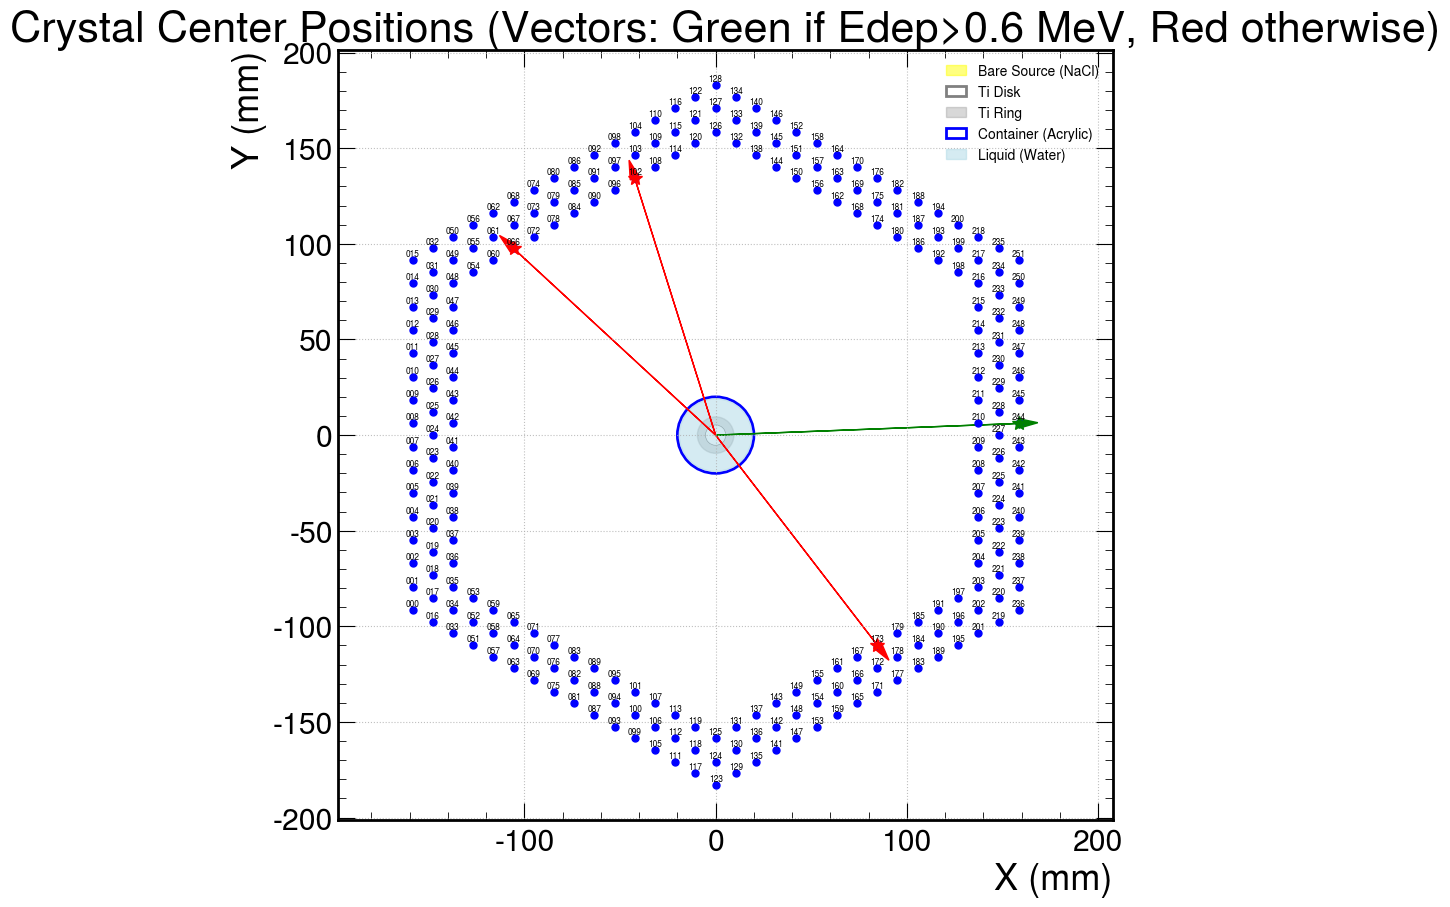

In [243]:
# Mimicked usage snippet (assuming 'filtered_data' and 'data' are your DataFrames)
eid = filtered_data["EventID"].unique()[2]
event_data = data[data["EventID"] == eid]
all_crystal = event_data["DetectorName"].values.tolist()
crystal_edeps = event_data["Edep_MeV"].values.tolist()  # Extract corresponding Edep_MeV
crystal_times = event_data["FirstTime_ns"].values.tolist()  # Extract corresponding FirstTime_ns
crystal_name = []
for crystal in all_crystal:
    current_name = crystal.split("UntitledPrism12.2mmcalor_")[-1].split("_")[-1]
    crystal_name.append(current_name)
plot_crystals_vectors(crystal_name, crystal_edeps, crystal_times)

Center position for calor_unit_152 (Edep=1.10 MeV, Time=0.00 ns): (x=42.26 mm, y=158.60 mm, z=0.00 mm)
Center position for calor_unit_138 (Edep=0.18 MeV, Time=28.00 ns): (x=21.13 mm, y=146.40 mm, z=0.00 mm)
Center position for calor_unit_150 (Edep=0.37 MeV, Time=28.00 ns): (x=42.26 mm, y=134.20 mm, z=0.00 mm)
Center position for calor_unit_158 (Edep=0.14 MeV, Time=0.00 ns): (x=52.83 mm, y=152.50 mm, z=0.00 mm)
Center position for calor_unit_099 (Edep=0.47 MeV, Time=28.00 ns): (x=-42.26 mm, y=-158.60 mm, z=0.00 mm)


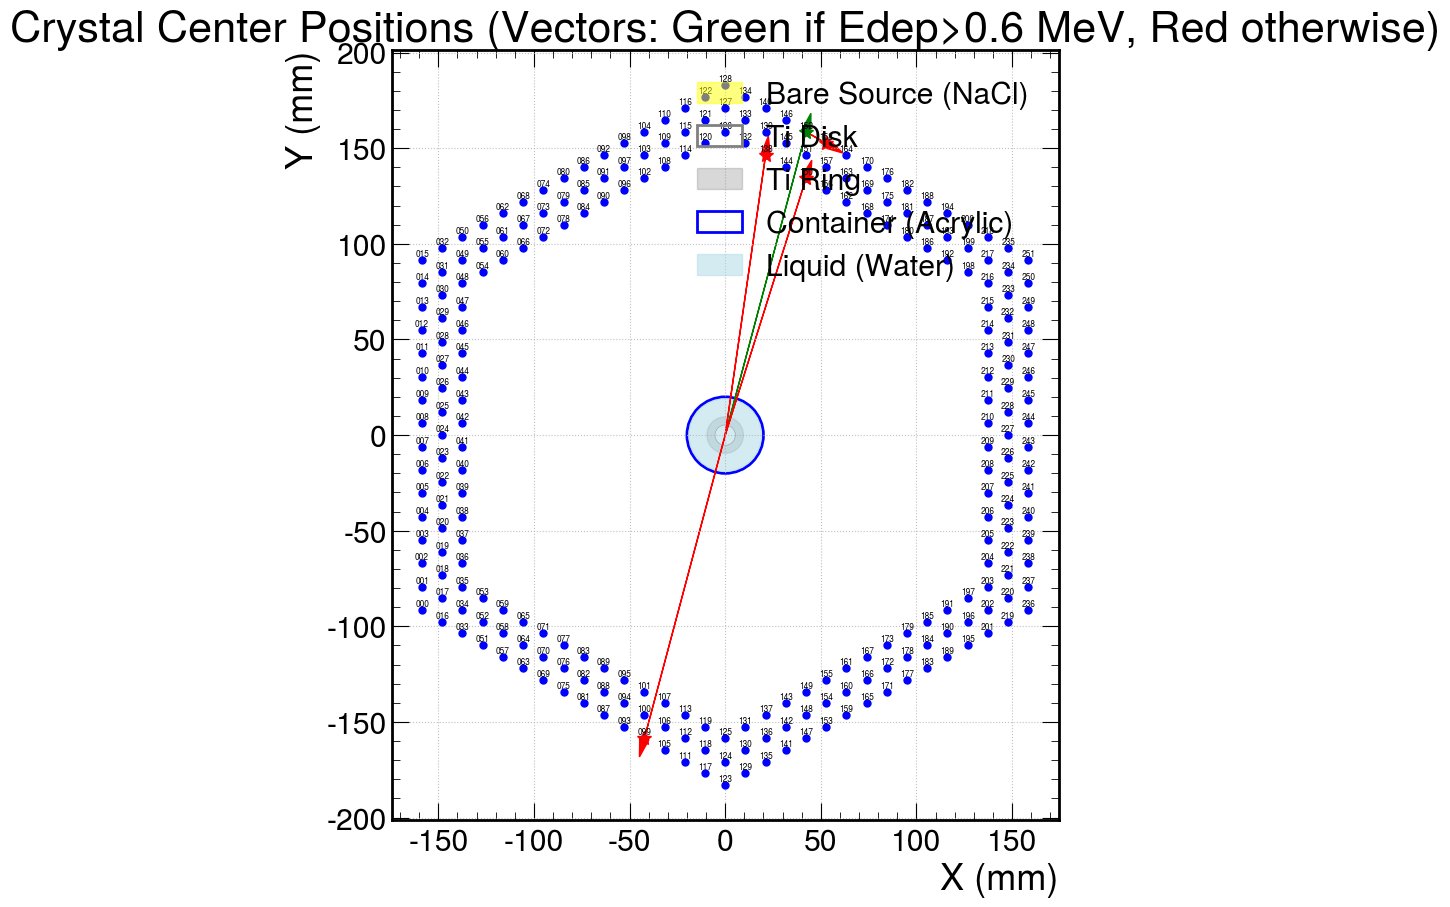

In [289]:
def plot_crystals_vectors(crystal_names, crystal_edeps, crystal_times):
    """
    Function to plot multiple crystal centers with vectors to each selected crystal in one plot.
    Vectors colored differently if edep > 0.6 MeV (green) else red.
    For low-energy crystals close to a high-energy one (>0.6 MeV), draw vector from the nearest high-energy crystal instead of center.
    Input: 
    - crystal_names (list of str): e.g., ['001', '002'], or full names like ['UntitledPrism12.2mmcalor_unit_001']
    - crystal_edeps (list of float): Corresponding Edep_MeV values for each crystal_name
    - crystal_times (list of float): Corresponding FirstTime_ns values for each crystal_name
    Extracts unit numbers and plots accordingly.
    """
    if len(crystal_names) != len(crystal_edeps) or len(crystal_names) != len(crystal_times):
        raise ValueError("crystal_names, crystal_edeps, and crystal_times must have the same length.")
    
    selected_units = []
    unit_edeps = {}
    unit_times = {}
    for i, name in enumerate(crystal_names):
        # Extract the number part (e.g., '001' or '72' from input)
        match = re.search(r'(\d+)$', name)  # Look for any digits at the end
        if match:
            num_str = match.group(1)
            unit_num = num_str.zfill(3)  # Pad to 3 digits, e.g., '72' -> '072'
            unit_key = f"calor_unit_{unit_num}"
            selected_units.append(unit_key)
            unit_edeps[unit_key] = crystal_edeps[i]
            unit_times[unit_key] = crystal_times[i]
        else:
            raise ValueError(f"Could not extract unit number (e.g., '001' or '72') from {name}.")
    
    # Generate centers
    prism_half_length = 6.1  # mm, based on 12.2 mm naming
    a1_x = 2 * prism_half_length * np.cos(np.deg2rad(30))
    a1_y = 2 * prism_half_length * np.sin(np.deg2rad(30))
    a2_x = 0.0
    a2_y = 2 * prism_half_length
    min_n = 13
    max_n = 15
    count = 0
    centers = {}
    for n1 in range(-max_n, max_n + 1):
        for n2 in range(max(-max_n, -n1 - max_n), min(max_n, -n1 + max_n) + 1):
            ring = max(abs(n1), abs(n2), abs(n1 + n2))
            if min_n <= ring <= max_n:
                x = n1 * a1_x + n2 * a2_x
                y = n1 * a1_y + n2 * a2_y
                z = 0.0
                unit_name = f"calor_unit_{count:03d}"  # Format as calor_unit_000, etc.
                centers[unit_name] = (x, y, z)
                count += 1
    
    # Plot
    fig, ax = plt.subplots()
    for unit, (x, y, z) in centers.items():
        ax.plot(x, y, 'bo', markersize=5)  # All centers in blue
        # Add small detector id label on top of each crystal
        detector_id = unit.split('_')[-1]  # e.g., '000'
        ax.text(x, y + 1, detector_id, fontsize=6, ha='center', va='bottom')  # Small text above point
    
    # Draw positronium source cross-section at center (top view, circles)
    disk_radius = 9.53 / 2  # mm
    ring_radius = 19.1 / 2  # mm
    # Bare source (inner circle, yellow for NaCl)
    bare_circle = plt.Circle((0, 0), disk_radius, color='yellow', fill=True, alpha=0.5, label='Bare Source (NaCl)')
    ax.add_patch(bare_circle)
    # Disk (Ti, thin, but same radius, overlay gray)
    disk_circle = plt.Circle((0, 0), disk_radius, color='gray', fill=False, linewidth=2, label='Ti Disk')
    ax.add_patch(disk_circle)
    # Ring (Ti, outer)
    ring_circle = plt.Circle((0, 0), ring_radius, color='gray', fill=True, alpha=0.3, label='Ti Ring')
    ax.add_patch(ring_circle)
    ring_inner = plt.Circle((0, 0), disk_radius, color='white', fill=True)  # Cut out inner for ring
    ax.add_patch(ring_inner)
    
    # Draw container (cylinder cross-section: outer Acrylic, inner Liquid/Water)
    container_radius = 20.0  # mm (2 cm)
    container_thickness = 1.0  # mm
    liquid_radius = container_radius - container_thickness  # 19 mm
    # Outer container (Acrylic, blue outline)
    container_outer = plt.Circle((0, 0), container_radius, color='blue', fill=False, linewidth=2, label='Container (Acrylic)')
    ax.add_patch(container_outer)
    # Inner liquid (Water, light blue fill)
    liquid_circle = plt.Circle((0, 0), liquid_radius, color='lightblue', fill=True, alpha=0.5, label='Liquid (Water)')
    ax.add_patch(liquid_circle)
    
    missing = []
    # Separate high-energy and low-energy units
    high_energy_units = [u for u in selected_units if unit_edeps[u] > 0.6]
    low_energy_units = [u for u in selected_units if unit_edeps[u] <= 0.6]
    
    # Get positions for selected units
    selected_pos = np.array([centers[u][:2] for u in selected_units if u in centers])  # (N, 2)
    high_pos = np.array([centers[u][:2] for u in high_energy_units if u in centers])  # (M, 2)
    low_pos = np.array([centers[u][:2] for u in low_energy_units if u in centers])  # (K, 2)
    
    # Draw vectors for high-energy (from center, green)
    for u in high_energy_units:
        if u in centers:
            sx, sy, sz = centers[u]
            edep = unit_edeps[u]
            time = unit_times[u]
            color = 'g'
            ax.arrow(0, 0, sx, sy, head_width=5, head_length=10, fc=color, ec=color)
            ax.plot(sx, sy, f'{color}*', markersize=10)
            print(f"Center position for {u} (Edep={edep:.2f} MeV, Time={time:.2f} ns): (x={sx:.2f} mm, y={sy:.2f} mm, z={sz:.2f} mm)")
    
    # For low-energy: Check if close to any high-energy, draw from nearest high if yes, else from center (red)
    if len(high_pos) > 0 and len(low_pos) > 0:
        dists = cdist(low_pos, high_pos)  # (K, M)
        min_dists = np.min(dists, axis=1)
        nearest_high_idx = np.argmin(dists, axis=1)
        threshold = 13.0  # mm, approximate nearest neighbor distance in lattice (~12.2 mm)
        
        for i, u in enumerate(low_energy_units):
            if u in centers:
                sx, sy, sz = centers[u]
                edep = unit_edeps[u]
                time = unit_times[u]
                color = 'r'
                if min_dists[i] <= threshold:
                    # Draw from nearest high-energy
                    nearest_high_pos = high_pos[nearest_high_idx[i]]
                    ax.arrow(nearest_high_pos[0], nearest_high_pos[1], sx - nearest_high_pos[0], sy - nearest_high_pos[1],
                             head_width=5, head_length=10, fc=color, ec=color)
                else:
                    # Draw from center
                    ax.arrow(0, 0, sx, sy, head_width=5, head_length=10, fc=color, ec=color)
                ax.plot(sx, sy, f'{color}*', markersize=10)
                print(f"Center position for {u} (Edep={edep:.2f} MeV, Time={time:.2f} ns): (x={sx:.2f} mm, y={sy:.2f} mm, z={sz:.2f} mm)")
    else:
        # If no high, draw all low from center
        for u in low_energy_units:
            if u in centers:
                sx, sy, sz = centers[u]
                edep = unit_edeps[u]
                time = unit_times[u]
                color = 'r'
                ax.arrow(0, 0, sx, sy, head_width=5, head_length=10, fc=color, ec=color)
                ax.plot(sx, sy, f'{color}*', markersize=10)
                print(f"Center position for {u} (Edep={edep:.2f} MeV, Time={time:.2f} ns): (x={sx:.2f} mm, y={sy:.2f} mm, z={sz:.2f} mm)")
    
    if missing:
        print(f"Detector units not found: {', '.join(missing)}")
    
    ax.set_aspect('equal')  # Equal axis scaling
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title('Crystal Center Positions (Vectors: Green if Edep>0.6 MeV, Red otherwise)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Mimicked usage snippet (assuming 'filtered_data' and 'data' are your DataFrames)
eid = filtered_data["EventID"].unique()[100]
event_data = data[data["EventID"] == eid]
all_crystal = event_data["DetectorName"].values.tolist()
crystal_edeps = event_data["Edep_MeV"].values.tolist()  # Extract corresponding Edep_MeV
crystal_times = event_data["FirstTime_ns"].values.tolist()  # Extract corresponding FirstTime_ns
crystal_name = []
for crystal in all_crystal:
    current_name = crystal.split("UntitledPrism12.2mmcalor_")[-1].split("_")[-1]
    crystal_name.append(current_name)
plot_crystals_vectors(crystal_name, crystal_edeps, crystal_times)

Center position for calor_unit_177 (Edep=0.51 MeV, Time=0.00 ns): (x=95.09 mm, y=-128.10 mm, z=0.00 mm)
Center position for calor_unit_078 (Edep=0.51 MeV, Time=0.00 ns): (x=-84.52 mm, y=109.80 mm, z=0.00 mm)


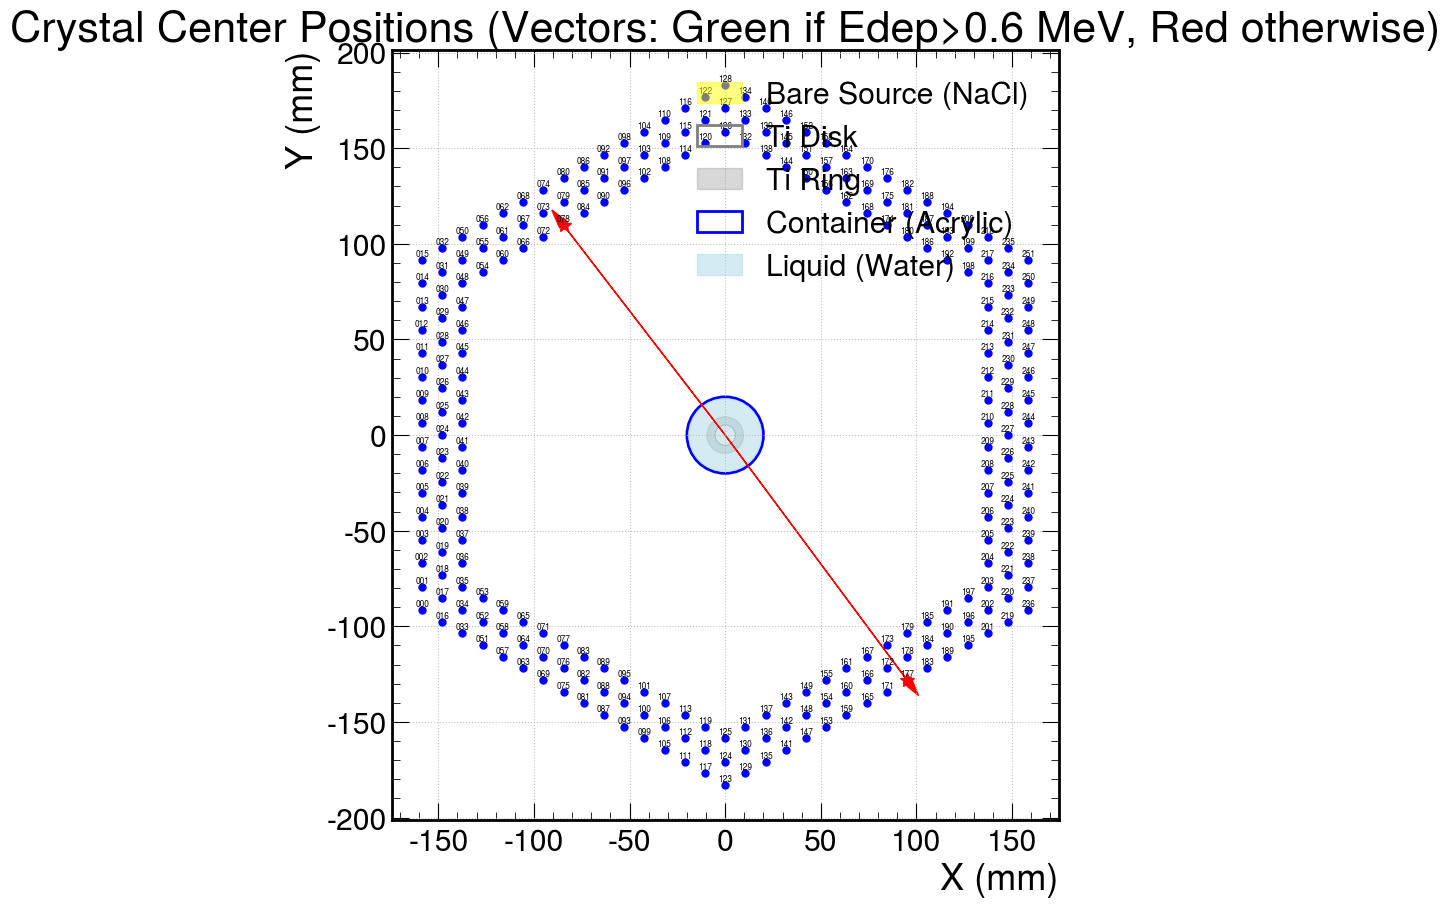

In [14]:
data=pd.read_csv('filtered_events.csv')
index=data.groupby('EventID')['Edep_MeV'].count()<=4
filtered_data=data[data['EventID'].isin(index[index].index)]
index=data.groupby('EventID')['Edep_MeV'].count()>=2
filtered_data=data[data['EventID'].isin(index[index].index)]
def plot_crystals_vectors(crystal_names, crystal_edeps, crystal_times):
    """
    Function to plot multiple crystal centers with vectors to each selected crystal in one plot.
    Vectors colored differently if edep > 0.6 MeV (green) else red.
    Input: 
    - crystal_names (list of str): e.g., ['001', '002'], or full names like ['UntitledPrism12.2mmcalor_unit_001']
    - crystal_edeps (list of float): Corresponding Edep_MeV values for each crystal_name
    - crystal_times (list of float): Corresponding FirstTime_ns values for each crystal_name
    Extracts unit numbers and plots accordingly.
    """
    if len(crystal_names) != len(crystal_edeps) or len(crystal_names) != len(crystal_times):
        raise ValueError("crystal_names, crystal_edeps, and crystal_times must have the same length.")
    
    selected_units = []
    unit_edeps = {}
    unit_times = {}
    for i, name in enumerate(crystal_names):
        # Extract the number part (e.g., '001' or '72' from input)
        match = re.search(r'(\d+)$', name)  # Look for any digits at the end
        if match:
            num_str = match.group(1)
            unit_num = num_str.zfill(3)  # Pad to 3 digits, e.g., '72' -> '072'
            unit_key = f"calor_unit_{unit_num}"
            selected_units.append(unit_key)
            unit_edeps[unit_key] = crystal_edeps[i]
            unit_times[unit_key] = crystal_times[i]
        else:
            raise ValueError(f"Could not extract unit number (e.g., '001' or '72') from {name}.")
    
    # Generate centers
    prism_half_length = 6.1  # mm, based on 12.2 mm naming
    a1_x = 2 * prism_half_length * np.cos(np.deg2rad(30))
    a1_y = 2 * prism_half_length * np.sin(np.deg2rad(30))
    a2_x = 0.0
    a2_y = 2 * prism_half_length
    min_n = 13
    max_n = 15
    count = 0
    centers = {}
    for n1 in range(-max_n, max_n + 1):
        for n2 in range(max(-max_n, -n1 - max_n), min(max_n, -n1 + max_n) + 1):
            ring = max(abs(n1), abs(n2), abs(n1 + n2))
            if min_n <= ring <= max_n:
                x = n1 * a1_x + n2 * a2_x
                y = n1 * a1_y + n2 * a2_y
                z = 0.0
                unit_name = f"calor_unit_{count:03d}"  # Format as calor_unit_000, etc.
                centers[unit_name] = (x, y, z)
                count += 1
    
    # Neighbor threshold (approx hex spacing ~12.2 mm, with buffer)
    neighbor_threshold = 12.2 * 1.1  # mm
    
    # Plot
    fig, ax = plt.subplots()
    for unit, (x, y, z) in centers.items():
        ax.plot(x, y, 'bo', markersize=5)  # All centers in blue
        # Add small detector id label on top of each crystal
        detector_id = unit.split('_')[-1]  # e.g., '000'
        ax.text(x, y + 1, detector_id, fontsize=6, ha='center', va='bottom')  # Small text above point
    
    # Draw positronium source cross-section at center (top view, circles)
    disk_radius = 9.53 / 2  # mm
    ring_radius = 19.1 / 2  # mm
    # Bare source (inner circle, yellow for NaCl)
    bare_circle = plt.Circle((0, 0), disk_radius, color='yellow', fill=True, alpha=0.5, label='Bare Source (NaCl)')
    ax.add_patch(bare_circle)
    # Disk (Ti, thin, but same radius, overlay gray)
    disk_circle = plt.Circle((0, 0), disk_radius, color='gray', fill=False, linewidth=2, label='Ti Disk')
    ax.add_patch(disk_circle)
    # Ring (Ti, outer)
    ring_circle = plt.Circle((0, 0), ring_radius, color='gray', fill=True, alpha=0.3, label='Ti Ring')
    ax.add_patch(ring_circle)
    ring_inner = plt.Circle((0, 0), disk_radius, color='white', fill=True)  # Cut out inner for ring
    ax.add_patch(ring_inner)
    
    # Draw container (cylinder cross-section: outer Acrylic, inner Liquid/Water)
    container_radius = 20.0  # mm (2 cm)
    container_thickness = 1.0  # mm
    liquid_radius = container_radius - container_thickness  # 19 mm
    # Outer container (Acrylic, blue outline)
    container_outer = plt.Circle((0, 0), container_radius, color='blue', fill=False, linewidth=2, label='Container (Acrylic)')
    ax.add_patch(container_outer)
    # Inner liquid (Water, light blue fill)
    liquid_circle = plt.Circle((0, 0), liquid_radius, color='lightblue', fill=True, alpha=0.5, label='Liquid (Water)')
    ax.add_patch(liquid_circle)
    
    # Filter selected centers
    selected_centers = {u: centers[u] for u in selected_units if u in centers}
    
    # High-energy units (>0.6 MeV)
    high_energy = [u for u in selected_units if unit_edeps[u] > 0.6]
    
    handled = set()
    missing = []
    
    # Handle high-energy and their close neighbors
    for he in high_energy:
        if he not in centers:
            missing.append(he)
            continue
        sx, sy, sz = selected_centers[he]
        time = unit_times[he]
        edep = unit_edeps[he]
        color = 'g'
        # Draw from center to high-energy
        ax.arrow(0, 0, sx, sy, head_width=5, head_length=10, fc=color, ec=color)
        ax.plot(sx, sy, f'{color}*', markersize=10)
        print(f"Center position for {he} (Edep={edep:.2f} MeV, Time={time:.2f} ns): (x={sx:.2f} mm, y={sy:.2f} mm, z={sz:.2f} mm)")
        handled.add(he)
        
        # Find and draw to close neighbors
        for other in selected_units:
            if other != he and other not in handled:
                if other not in selected_centers:
                    continue
                ox, oy, oz = selected_centers[other]
                dist = np.sqrt((sx - ox)**2 + (sy - oy)**2)
                if dist < neighbor_threshold:
                    o_edep = unit_edeps[other]
                    o_time = unit_times[other]
                    o_color = 'g' if o_edep > 0.6 else 'r'
                    # Draw from high-energy to neighbor
                    ax.arrow(sx, sy, ox - sx, oy - sy, head_width=5, head_length=10, fc=o_color, ec=o_color)
                    ax.plot(ox, oy, f'{o_color}*', markersize=10)
                    print(f"Center position for {other} (Edep={o_edep:.2f} MeV, Time={o_time:.2f} ns): (x={ox:.2f} mm, y={oy:.2f} mm, z={oz:.2f} mm)")
                    handled.add(other)
    
    # Remaining triggered crystals
    remaining = [u for u in selected_units if u not in handled and u in selected_centers]
    
    if remaining:
        # Get positions for remaining
        positions = np.array([selected_centers[u] for u in remaining])
        # Use hierarchical clustering with linkage
        if len(positions) > 1:
            Z = linkage(positions, method='single', metric='euclidean')
            clusters = fcluster(Z, t=neighbor_threshold, criterion='distance')
        else:
            clusters = np.array([1])  # Single cluster
        
        # For each cluster
        cluster_dict = {}
        for i, c in enumerate(clusters):
            if c not in cluster_dict:
                cluster_dict[c] = []
            cluster_dict[c].append(remaining[i])
        
        for cl, units in cluster_dict.items():
            # Pick primitive: closest to center in this cluster
            dists = {u: np.sqrt(selected_centers[u][0]**2 + selected_centers[u][1]**2) for u in units}
            primitive = min(dists, key=dists.get)
            px, py, pz = selected_centers[primitive]
            p_edep = unit_edeps[primitive]
            p_time = unit_times[primitive]
            p_color = 'g' if p_edep > 0.6 else 'r'
            # Draw from center to primitive
            ax.arrow(0, 0, px, py, head_width=5, head_length=10, fc=p_color, ec=p_color)
            ax.plot(px, py, f'{p_color}*', markersize=10)
            print(f"Center position for {primitive} (Edep={p_edep:.2f} MeV, Time={p_time:.2f} ns): (x={px:.2f} mm, y={py:.2f} mm, z={pz:.2f} mm)")
            handled.add(primitive)
            
            # Find and draw to close neighbors in cluster
            for other in [u for u in units if u != primitive]:
                ox, oy, oz = selected_centers[other]
                dist = np.sqrt((px - ox)**2 + (py - oy)**2)
                if dist < neighbor_threshold:
                    o_edep = unit_edeps[other]
                    o_time = unit_times[other]
                    o_color = 'g' if o_edep > 0.6 else 'r'
                    # Draw from primitive to neighbor
                    ax.arrow(px, py, ox - px, oy - py, head_width=5, head_length=10, fc=o_color, ec=o_color)
                    ax.plot(ox, oy, f'{o_color}*', markersize=10)
                    print(f"Center position for {other} (Edep={o_edep:.2f} MeV, Time={o_time:.2f} ns): (x={ox:.2f} mm, y={oy:.2f} mm, z={oz:.2f} mm)")
                    handled.add(other)
    
    # For any isolated remaining (not clustered), draw from center
    isolated = [u for u in selected_units if u not in handled and u in selected_centers]
    for iso in isolated:
        ix, iy, iz = selected_centers[iso]
        i_edep = unit_edeps[iso]
        i_time = unit_times[iso]
        i_color = 'g' if i_edep > 0.6 else 'r'
        ax.arrow(0, 0, ix, iy, head_width=5, head_length=10, fc=i_color, ec=i_color)
        ax.plot(ix, iy, f'{i_color}*', markersize=10)
        print(f"Center position for {iso} (Edep={i_edep:.2f} MeV, Time={i_time:.2f} ns): (x={ix:.2f} mm, y={iy:.2f} mm, z={iz:.2f} mm)")
    
    if missing:
        print(f"Detector units not found: {', '.join(missing)}")
    
    ax.set_aspect('equal')  # Equal axis scaling
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title('Crystal Center Positions (Vectors: Green if Edep>0.6 MeV, Red otherwise)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Mimicked usage snippet (assuming 'filtered_data' and 'data' are your DataFrames)
eid = filtered_data["EventID"].unique()[4]
event_data = data[data["EventID"] == eid]
all_crystal = event_data["DetectorName"].values.tolist()
crystal_edeps = event_data["Edep_MeV"].values.tolist()  # Extract corresponding Edep_MeV
crystal_times = event_data["FirstTime_ns"].values.tolist()  # Extract corresponding FirstTime_ns
crystal_name = []
for crystal in all_crystal:
    current_name = crystal.split("UntitledPrism12.2mmcalor_")[-1].split("_")[-1]
    crystal_name.append(current_name)
plot_crystals_vectors(crystal_name, crystal_edeps, crystal_times)

In [312]:
filtered_data["EventID"].unique()

array([    1,     2,     5, ..., 99957, 99958, 99959], shape=(47160,))

Center position for calor_unit_148 (Edep=1.05 MeV, Time=0.00 ns): (x=42.26 mm, y=-146.40 mm, z=0.00 mm)
Center position for calor_unit_143 (Edep=0.23 MeV, Time=0.00 ns): (x=31.70 mm, y=-140.30 mm, z=0.00 mm)
Center position for calor_unit_214 (Edep=0.02 MeV, Time=128.00 ns): (x=137.35 mm, y=54.90 mm, z=0.00 mm)
Center position for calor_unit_231 (Edep=0.27 MeV, Time=128.00 ns): (x=147.92 mm, y=48.80 mm, z=0.00 mm)


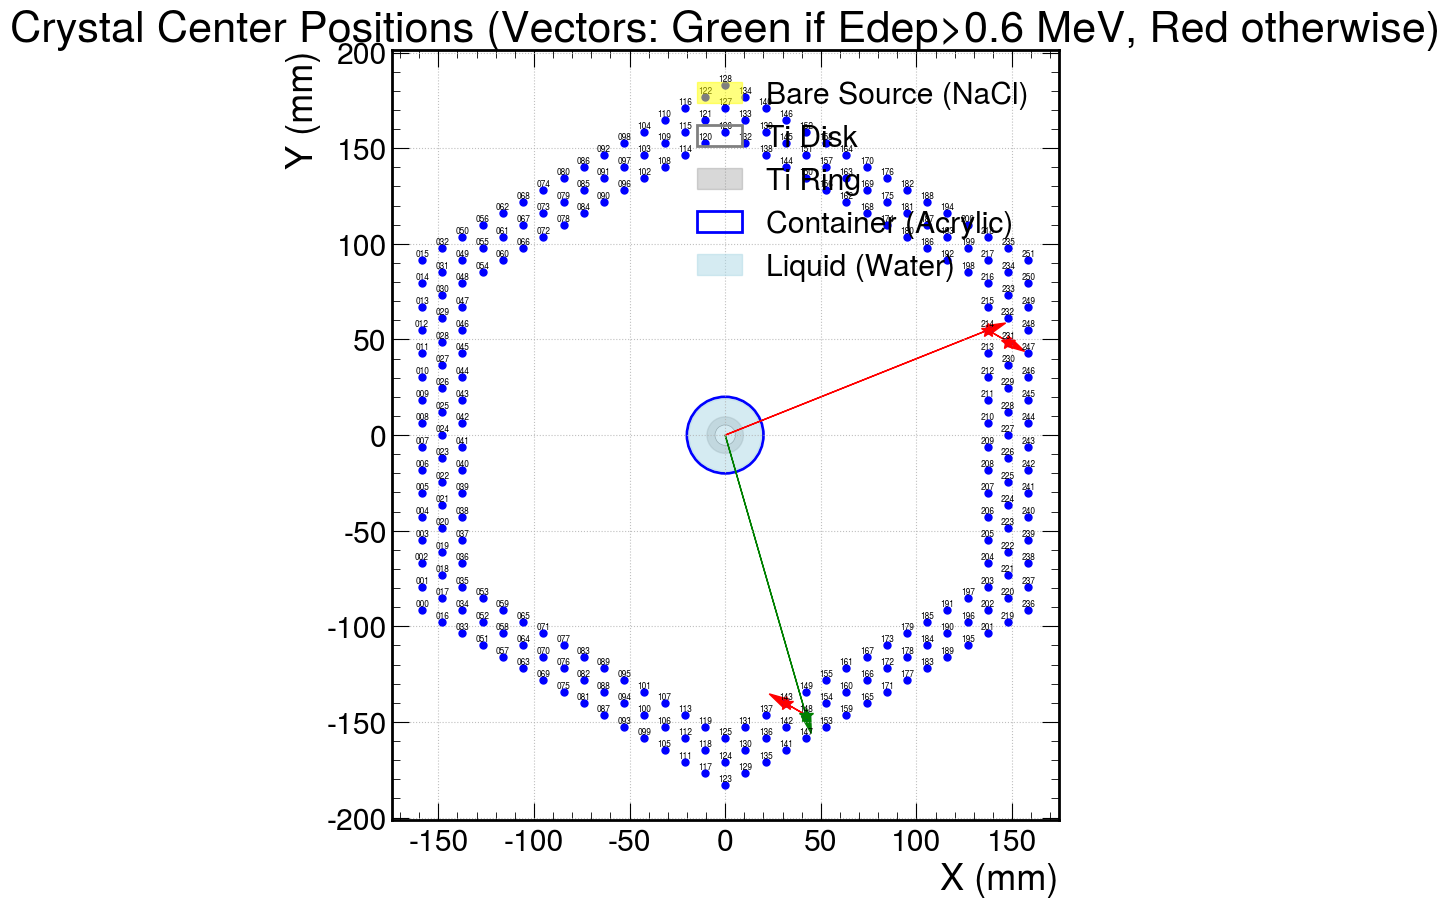

In [34]:
test=pd.read_csv('filtered_events.csv')
index=test.groupby('EventID')['Edep_MeV'].count()==4
filtered_data=test[test['EventID'].isin(index[index].index)]
#index=test.groupby('EventID')['Edep_MeV'].count()>=2
#filtered_data=test[test['EventID'].isin(index[index].index)]
eid = filtered_data["EventID"].unique()[4]
event_data = test[test["EventID"] == eid]
all_crystal = event_data["DetectorName"].values.tolist()
crystal_edeps = event_data["Edep_MeV"].values.tolist()  # Extract corresponding Edep_MeV
crystal_times = event_data["FirstTime_ns"].values.tolist()  # Extract corresponding FirstTime_ns
crystal_name = []
for crystal in all_crystal:
    current_name = crystal.split("UntitledPrism12.2mmcalor_")[-1].split("_")[-1]
    crystal_name.append(current_name)
plot_crystals_vectors(crystal_name, crystal_edeps, crystal_times)